In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import re

In [4]:
datapath = "Datasets/Multivariate DBS data 2015-2025.xlsx"
df = pd.read_excel(datapath)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

df.head()


Price   Open   High    Low Change %  vol_clean Event  \
Date                                                               
2015-01-02  18.06  18.14  18.17  18.02   -0.50%  1670000.0   NaN   
2015-01-03  18.06  18.14  18.17  18.02   -0.50%  1670000.0   NaN   
2015-01-04  17.65  17.93  17.96  17.62   -0.50%  4310000.0   NaN   
2015-01-05  17.65  17.93  17.96  17.62   -2.27%  4310000.0   NaN   
2015-01-06  17.47  17.48  17.50  17.39   -1.02%  5670000.0   NaN   

           Event_Description Is_Event_Positive  is_event_day  \
Date                                                           
2015-01-02               NaN               NaN             0   
2015-01-03               NaN               NaN             0   
2015-01-04               NaN               NaN             0   
2015-01-05               NaN               NaN             0   
2015-01-06               NaN               NaN             0   

            is_event_positive_flag  is_covid_period  regime  
Date                                                         
2015-01-02                       0                0       0  
2015-01-03                       0                0       0  
2015-01-04                       0                0       0  
2015-01-05                       0                0       0  
2015-01-06                       0                0       0

In [5]:
scaler = MinMaxScaler()
# Drop 'Vol.' column if it exists
if 'Vol.' in df.columns:
    df = df.drop(columns=['Vol.'])
# Map common boolean-like strings to numeric
df = df.replace({'Yes': 1, 'No': 0, 'yes': 1, 'no': 0, 'True': 1, 'False': 0, 'true': 1, 'false': 0})
# For any remaining object/string columns, try to remove common non-numeric chars and coerce to numeric
for col in df.columns:
    if df[col].dtype == object or pd.api.types.is_string_dtype(df[col]):
        # remove commas and currency symbols, percent handled separately if needed
        try:
            cleaned = df[col].astype(str).str.replace(',', '').str.replace('$', '').str.replace('£', '').str.replace('€', '')
            # coerce to numeric where possible; non-convertible values become NaN
            df[col] = pd.to_numeric(cleaned, errors='ignore')
        except Exception:
            pass
# Select numeric columns only for scaling
numeric_df = df.select_dtypes(include=[np.number])
if numeric_df.shape[1] == 0:
    raise ValueError('No numeric columns available for scaling after coercion.')
# Choose a target column: prefer common price/close names if present, else use first numeric column
preferred_targets = ['Price','Low','High','Open']
target_col = None
for t in preferred_targets:
    if t in numeric_df.columns:
        target_col = t
        break
if target_col is None:
    target_col = numeric_df.columns[0]
# Reorder so target is first column (create_sequences expects target at index 0)
cols = [target_col] + [c for c in numeric_df.columns if c != target_col]
numeric_df = numeric_df[cols]
# Fit scaler on numeric values and keep numeric_df for later inverse transforms
scaled_data = scaler.fit_transform(numeric_df.values)
print('target column used for forecasting:', target_col)
print('scaled_data shape:', scaled_data.shape)
numeric_df.head()

target column used for forecasting: Price
scaled_data shape: (4047, 11)


C:\Users\colle\AppData\Local\Temp\ipykernel_12152\1425231136.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'Yes': 1, 'No': 0, 'yes': 1, 'no': 0, 'True': 1, 'False': 0, 'true': 1, 'false': 0})
C:\Users\colle\AppData\Local\Temp\ipykernel_12152\1425231136.py:14: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(cleaned, errors='ignore')
C:\Users\colle\AppData\Local\Temp\ipykernel_12152\1425231136.py:14: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(cleaned, errors='

Price   Open   High    Low  vol_clean  Event  Is_Event_Positive  \
Date                                                                          
2015-01-02  18.06  18.14  18.17  18.02  1670000.0    NaN                NaN   
2015-01-03  18.06  18.14  18.17  18.02  1670000.0    NaN                NaN   
2015-01-04  17.65  17.93  17.96  17.62  4310000.0    NaN                NaN   
2015-01-05  17.65  17.93  17.96  17.62  4310000.0    NaN                NaN   
2015-01-06  17.47  17.48  17.50  17.39  5670000.0    NaN                NaN   

            is_event_day  is_event_positive_flag  is_covid_period  regime  
Date                                                                       
2015-01-02             0                       0                0       0  
2015-01-03             0                       0                0       0  
2015-01-04             0                       0                0       0  
2015-01-05             0                       0                0       0  
2015-01-06             0                       0                0       0

In [6]:
def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i + window])
        y.append(data[i + window, 0])
    return np.array(X), np.array(y)


X, y = create_sequences(scaled_data, 20)

In [7]:
split = int(0.85 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [8]:
model = keras.Sequential()
model.add(keras.layers.LSTM(100, input_shape=(
    X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1))

model.compile(loss="mse", optimizer="adam", metrics=["mae"])
model.summary()

c:\Users\colle\anaconda3\envs\granite\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        44,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,501 (173.83 KB)

 Trainable params: 44,501 (173.83 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(X_train, y_train, epochs=30, batch_size=16)

Epoch 1/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0033 - mae: 0.0379
Epoch 2/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 9.6732e-04 - mae: 0.0231
Epoch 3/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.7006e-04 - mae: 0.0193
Epoch 4/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.6397e-04 - mae: 0.0175
Epoch 5/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.8666e-04 - mae: 0.0164
Epoch 6/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.7276e-04 - mae: 0.0158
Epoch 7/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4.0217e-04 - mae: 0.0146
Epoch 8/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.1728e-04 - mae: 0.0148
Epoch 9/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.0775e-04 - mae: 0.0147
Epoch 10/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.2751e-04 - mae: 0.0131
Epoch 11/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.4448e-04 - mae: 0.0133
Epoch 12/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.13

In [19]:
pred = model.predict(X_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [23]:
y_test_inv = scaler.inverse_transform(
    np.c_[y_test, np.zeros((len(y_test), numeric_df.shape[1] - 1))]
)[:, 0]

pred_inv = scaler.inverse_transform(
    np.c_[pred, np.zeros((len(pred), numeric_df.shape[1] - 1))]
)[:, 0]

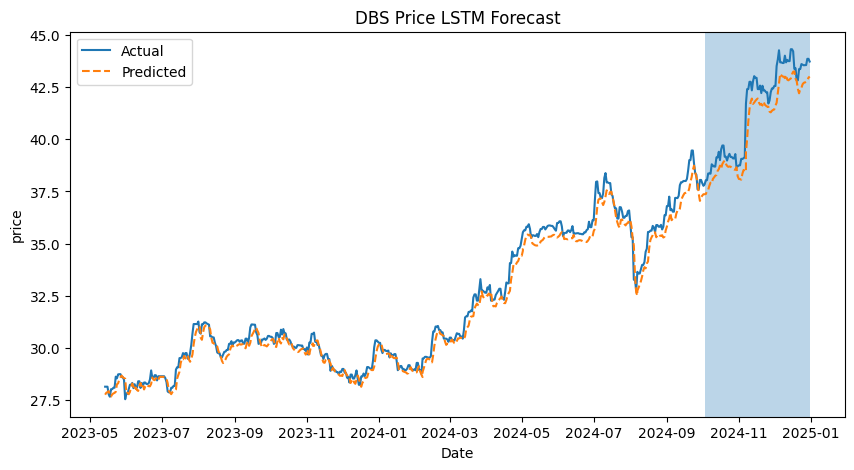

In [25]:
time = df.index[-len(y_test):]

plt.figure(figsize=(10, 5))
plt.plot(time, y_test_inv, label="Actual")
plt.plot(time, pred_inv, linestyle="--", label="Predicted")

highlight = int(len(time) * 0.85)
plt.axvspan(time[highlight], time[-1], alpha=0.3)

plt.title("DBS Price LSTM Forecast")
plt.xlabel("Date")
plt.ylabel("price")
plt.legend()
plt.show()

In [27]:
mse = mean_squared_error(y_test_inv, pred_inv)
mae = mean_absolute_error(y_test_inv, pred_inv)
r2 = r2_score(y_test_inv, pred_inv)

print("MSE: ",mse)
print("MAE: ",mae)
print("R2: ",r2)

MSE:  0.3134834321926325
MAE:  0.4231576625420536
R2:  0.9849188286479156
